# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

### Work:

#### part a 

-> 1st question by Mohit (Stereo dense reconstruction)

-> 2nd question by Raja  (Motion estimation using iterative PnP)

#### part b

-> By Raja and Mohit

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [43]:
#import libraries:
import numpy as np 
from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d
import matplotlib.pyplot as plt

In [44]:
def read_transformations(filename='./mr2020_project_data/poses.txt'):
    f = open(filename, 'r')
    lines = f.readlines()
    transformation_list = []
    for i in range(len(lines)):
        transformation_list_temp = lines[i].split()
        temp_rot = [] 
        temp_rot.append( (transformation_list_temp[0:4] ) ) 
        temp_rot.append( (transformation_list_temp[4:8]  ) ) 
        temp_rot.append( (transformation_list_temp[8:12]  ) ) 
        transformation_list.append(temp_rot)
    return transformation_list
tr_list=np.array(read_transformations())
tr_list=tr_list.flatten()
tr_mat_list = list(map(float, tr_list)) 
tr_mat_list=np.array(tr_mat_list)
tr_mat_list=tr_mat_list.reshape(21,3,4)
print(tr_list.shape,tr_mat_list.shape)

(252,) (21, 3, 4)


Provide explanation in this cell: 


In [45]:
#your code here
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
             [0.000000e+00, 7.070912e+02, 1.831104e+02],
             [0.000000e+00, 0.000000e+00, 1.000000e+00]])
f=K[0][0]
b=0.53790448812

pcd_gl=o3d.geometry.PointCloud()
pcd = o3d.geometry.PointCloud()
pcd_list=[]

for i in range(21):
    # Read Corresponding Images
    img_1 = cv2.imread('./mr2020_project_data/img2/00000004'+str(i+60)+'.png')
    img_2 = cv2.imread('./mr2020_project_data/img3/00000004'+str(i+60)+'.png')
    print("Processing the image pair "+str(i+1))
    # Disparities using cv2.StereoSGBM
    stereo = cv2.StereoSGBM_create(minDisparity= -39,
           numDisparities = 144,
           blockSize = 5,
           uniquenessRatio = 10,
           speckleWindowSize = 150,
           speckleRange = 32,
           disp12MaxDiff = 1,
           P1 = 8*3*5**2,
           P2 =32*3*5**2,
           preFilterCap=63) 
    min_disp = -39
    num_disp = 144     
    disparity= stereo.compute(img_1, img_2).astype(np.float32) / 64
    disparity = (disparity-min_disp)/num_disp
    Dim = disparity.shape
    
    # Q matrix
    Q = np.array([[ 1,  0,  0, -Dim[1]/2],
                  [ 0,  -1,  0, Dim[0]/2],
                  [ 0,  0,  0, f],
                  [ 0,  0,  1/b, 0]])
    disparity_pts=[]
    for p in range(Dim[0]):
        for q in range(Dim[1]):
            disparity_pts.append([q,p,disparity[p,q],1])
    disparity_pts = np.array(disparity_pts)
    
    # Camera points w.r.t Disparity points
    cam_pts=[np.matmul(Q,m) for m in disparity_pts]
    cam_pts=np.array([c/c[3]for c in cam_pts])
    colors = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)    # Colors
    mask = disparity >= disparity.min()
    colors = colors[mask]/255
    
    # Generating World points from Cmaera points using Camera Poses  
    world_pts=np.matmul(tr_mat_list[i],cam_pts.T)
    world_pts[0]=-world_pts[0]
    print("Process Done")
    # PCD generation
    pcd.points = o3d.utility.Vector3dVector(world_pts.T)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    pcd_list.append(pcd)
    pcd_gl=pcd_gl+pcd
    
pts=np.asarray(pcd_gl.points)
clrs=np.asarray(pcd_gl.colors)
mask = ((abs(pts[:,1]) < 1500) & (abs(pts[:,2]) < 1500) & (abs(pts[:,0]) < 1500))
pts=pts[mask]
clrs=clrs[mask]
print(np.shape(pts))


pcd_gl.points=o3d.utility.Vector3dVector(pts)
pcd_gl.colors=o3d.utility.Vector3dVector(clrs)

o3d.visualization.draw_geometries([pcd_gl])
o3d.io.write_point_cloud("Output.pcd", pcd_gl)

Processing the image pair 1
Process Done
Processing the image pair 2
Process Done
Processing the image pair 3
Process Done
Processing the image pair 4
Process Done
Processing the image pair 5
Process Done
Processing the image pair 6
Process Done
Processing the image pair 7
Process Done
Processing the image pair 8
Process Done
Processing the image pair 9
Process Done
Processing the image pair 10
Process Done
Processing the image pair 11
Process Done
Processing the image pair 12
Process Done
Processing the image pair 13
Process Done
Processing the image pair 14
Process Done
Processing the image pair 15
Process Done
Processing the image pair 16
Process Done
Processing the image pair 17
Process Done
Processing the image pair 18
Process Done
Processing the image pair 19
Process Done
Processing the image pair 20
Process Done
Processing the image pair 21
Process Done
(7021724, 3)


True

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

In [46]:
def Gauss_newton(P,x_gt,X,N,tol): 
    Loss=[]
    for i in range(N):
        x = (P@X.T).T
        A = x_gt[:,0]/x_gt[:,2] - x[:,0]/x[:,2]
        B = x_gt[:,1]/x_gt[:,2] - x[:,1]/x[:,2]
        res = (np.hstack((A,B))).reshape(-1,1)
        k = (res.T@res/2/len(X)).item(0);
        
        print("\nLoss at Iteration "+str(i)+" is --",k)
        Loss.append(k)
        J = Jacobian(x,X);
        del_p = np.linalg.inv(J.T@J)@J.T@res;
        
        P = (P.reshape(12,1) - del_p).reshape(3,4);
        if(np.linalg.norm(del_p)<tol):
            break;
    Loss = np.array(Loss)
    return P,Loss, i

def Jacobian(x,X):
    L = len(X);
    X[:,0] = X[:,0]/x[:,2]
    X[:,1] = X[:,1]/x[:,2]
    X[:,2] = X[:,2]/x[:,2]
    X[:,3] = X[:,3]/x[:,2]
    x[:,0] = x[:,0]/x[:,2]
    x[:,1] = x[:,1]/x[:,2]    
    a1 = np.vstack((x[:,0]*X[:,0],x[:,0]*X[:,1]))
    a2 = np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3]))
    A = (np.vstack((a1,a2))).T    
    b1 = np.vstack((x[:,1]*X[:,0],x[:,1]*X[:,1]))
    b2 = np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3]))
    B = (np.vstack((b1,b2))).T    
    zeros = np.zeros((L,4))
    J_x = np.hstack((-X,np.hstack((zeros,A))))
    J_y = np.hstack((zeros,np.hstack((-X,B))))
    J = np.vstack((J_x,J_y))
    return J

def DLT(x,X):
    x[:,0] = x[:,0]/x[:,2];
    x[:,1] = x[:,1]/x[:,2];    
    a1 = np.vstack((x[:,0]*X[:,0],x[:,0]*X[:,1]))
    a2 = np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3]))
    A = (np.vstack((a1,a2))).T    
    b1 = np.vstack((x[:,1]*X[:,0],x[:,1]*X[:,1]))
    b2 = np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3]))
    B = (np.vstack((b1,b2))).T    
    zeros = np.zeros((len(X),4))
    Ax = np.hstack((-X,np.hstack((zeros,A))))
    Ay = np.hstack((zeros,np.hstack((-X,B))))   
    M = np.vstack((Ax,Ay))
    U,D,VT = np.linalg.svd(M)
    P = np.array(VT[-1]).reshape(3,4)
    P = P/P[-1,-1]
    return P

--------------------------------------------------Ground Truths--------------------------------------------------
P_GT :
  [[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

T_GT  :
  [[-9.09854768e-01  4.11782636e-02  4.12878417e-01 -1.92843773e+02]
 [ 5.44537786e-02  9.98307203e-01  2.04332712e-02  7.22435448e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]] 


--------------------------------------------------Optimization--------------------------------------------------

Loss at Iteration 0 is -- 22866961692.909214

Loss at Iteration 1 is -- 145583660.95846012

Loss at Iteration 2 is -- 217809.41798015666

Loss at Iteration 3 is -- 34833.26519634125

Loss at Iteration 4 is -- 68.44563162579314

Loss at Iteration 5 is -- 17.910054171127065

Loss at Iteration 6 is -- 1.4323182506227732

Loss at Iteration 7 is --

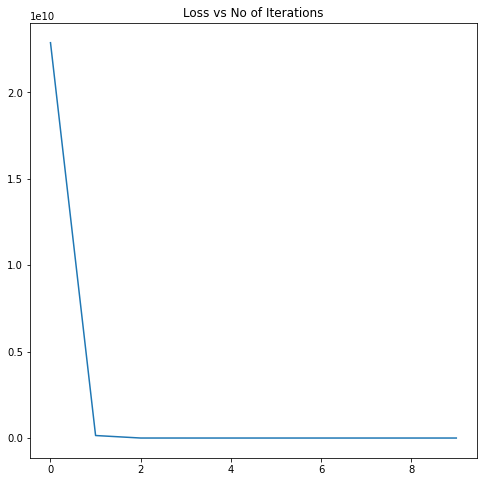

In [47]:
N=21
T=read_transformations()

pcd = o3d.io.read_point_cloud("Output.pcd") # Read the point cloud
points = np.array(pcd.points)
pcd_points=np.hstack((points,np.ones((len(points),1))))

X_gt = pcd_points[0::10,:]
T_gt = np.eye(4,4)
T_gt[:3,:4] = T[0]
T_gt = np.linalg.inv(T_gt)
P_gt = K@T_gt[:3,:4]
x_gt = (P_gt@X_gt.T).T
P_dlt = DLT(x_gt[:10,:],X_gt[:10,:])

print("-"*50 + "Ground Truths" + "-"*50)
print("P_GT :\n ",P_gt)
print("\nT_GT  :\n ",np.linalg.inv(K)@P_gt,"\n\n")

print("-"*50 + "Optimization" + "-"*50)
P_op, Cost, it_conv = Gauss_newton(P_dlt,x_gt,X_gt,1000,1e-4)
P_op = P_gt[-1,-1]*P_op/P_op[-1,-1] 
print("\n\n")

plt.figure(figsize=(8,8));
plt.plot(range(it_conv+1), Cost[0:it_conv+1]);
plt.title('Loss vs No of Iterations')

print("-"*50 + "Final Output" + "-"*50)
print("\nP_Output = ",P_op)
print("\nT_Output = ",np.linalg.inv(K)@P_op)

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: In practical cases we will take the images at different poses so we will know the pose/location so that knowing the camera_ind for each point
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: As previous we know the camera poses so we can find the correspondences using sift or other cv functions so that we can find the 3d-point using the triangulation because we know the camera points too , thus mapping from 2d-3d will make sure that we know the 2d-3d correspondances 
3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-3 - Transformations: Yes because rotation and translation is done with respect to a specific origin , so if we make the translation 1st then the origin is translated and the rotation is done by that origin not the previous one .

4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-4 - Jacobian: here m is total number of point values in whole images , which is take M images and N number of points in each image then it is finally equal to "M*N"(*2) only but here all the images donot consist of same number of points which is true in class problem so here total number of points should be given
5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes.  
        - Ans 5.1 - Jacobian & Parameters: in class we took projection matrix P we took as $3x4=12$ paramenters , but here we took angle rotaion = 6 parametes + 3 intrinsics of camera (focal length + 2 distortions) so 9
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 5.2 - Jacobian & Parameters: In class the number of unknowns for each camera=12 , here 9 , and for each new point it is 3 , here also it is same only , so unknowns in class lecture = n_camera * 12 + n_points * 3 here it is n_camera * 9 + n_points * 3 where n_camera is number of cameras and n_points is (number_of_images x number_of_points_per_image)/number_of_times_each_point_is_seen
6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - Ans 6 - Sparsity, Residual Vector & Jacobian: 
        1. it shows the sparsity of sparsity of jacobian where we set the locations where there is non-zero value to 1 ,for example n unknown parameters , m points we have then we have jac of (2m,n) size where non-zeros are only at a place where the parameters are used to predict secific point 
        
        2. residual size is 2m
        
        3. jacobian also has a different structure compared to class and we used scipy function to speed up the computations based on sparsity of the matrix
        

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**

1. we can use surf or sift or orb which returns keypoints and descriptors taking image and hessian threshold as input kp and des are float points

    surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000, extended = 1)

    kp, des = surf.detectAndCompute(test_img, None)
     - where as sift donot take hessian as input 
 
    sift = cv2.xfeatures2d.SIFT_create()

    kp, des = sift.detectAndCompute(test_img, None)
   
2. Now we got two sets of descriptors so to find correspondences we use knnmatcher with k=2 knnmatcher(des1,des2,2) (k=2 because correspondances between 2 images and des are descripted above step)function -> BFmatcher() for initialisation and knnmatcher for correpondances as said previously


3. apply ratio test and find best matches between neighbours p1 and p2


4. Then we will send it to F,mask=cv2.findFundamentalMat(p1,p2,cv2.FM_LMEDS) to find F or we can use normalised 8-point algo which does the same 


5. Now from K,F we find E as $E=K^T * F * K$


6. Now we have E,K now decompose them into R,t from temp1,R,t,temp2=cv2.recoverPose(E, p1, p2, K)where the 1st and last output values are not used here we use 2nd 3rd values as R,t input is E,K,p1,p2(points corresponding)


7. Now we use triangulation to find 3d points for SFM 